# Preliminaries and Dataframe Construction

In [2]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

#Import Encounters from Database Query
df = pd.read_pickle("encounters.pkl")
print(df.info())

#Seaborn Formatting
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Ensure line graphs display on graphs
sns.set_palette(sns.color_palette('colorblind')) #set color palette to a nice seaborn style https://seaborn.pydata.org/tutorial/color_palettes.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   EncounterID       3707 non-null   object  
 1   SubjectID         3707 non-null   object  
 2   Age               3707 non-null   float64 
 3   Race              3706 non-null   object  
 4   Ethnicity         3707 non-null   object  
 5   Sex               3707 non-null   object  
 6   InitialSOFA       3707 non-null   int64   
 7   StayLength        3707 non-null   float64 
 8   CCS_raw           3707 non-null   int64   
 9   CCS_age           3707 non-null   int64   
 10  CCS_Colorado      3707 non-null   int64   
 11  ECI_raw           3707 non-null   int64   
 12  LE                3707 non-null   float64 
 13  Cho_LE            3707 non-null   float64 
 14  COVID_Status      3707 non-null   int8    
 15  Discharge_Status  3707 non-null   int64   
 16  Intubation        3707 n

In [3]:
##Super useful function from https://stackoverflow.com/a/51734632

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    odds_ratio = np.exp(results.params)
    conf_lower = np.exp(results.conf_int()[0])
    conf_higher = np.exp(results.conf_int()[1])

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "odds_ratio":odds_ratio,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals", "odds_ratio","conf_lower","conf_higher"]]
    return results_df

### Multiple Variable Logistic Regression
Model of Survival controlling on SOFA score, Age, Covid+, Sex, Elixhauser and Race (with White, non-hispanic as treatment reference)

### Mupltiple Variable Logistic Regression (within Race)
Model of Survival controlling on SOFA score, Age, Covid+, Sex, and Elixhauser, using data within a racial group.

In [3]:
results_survival_all = smf.logit(formula="Survived ~ InitialSOFA + C(Race, Treatment(reference='White')) + Age + C(COVID_Status) + Sex + ECI_raw", data=df).fit()
results_survival_black = smf.logit(formula="Survived ~ InitialSOFA + Age + C(COVID_Status) + Sex + ECI_raw", data=df.where(df['Race']=='Black')).fit()
results_survival_hispanic = smf.logit(formula="Survived ~ InitialSOFA + Age + C(COVID_Status) + Sex + ECI_raw", data=df.where(df['Race']=='Hispanic')).fit()
results_survival_white = smf.logit(formula="Survived ~ InitialSOFA + Age + C(COVID_Status) + Sex + ECI_raw", data=df.where(df['Race']=='White')).fit()

print(results_survival_all.summary())

with pd.ExcelWriter("Log-regression-results.xlsx") as writer:
# use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    results_summary_to_dataframe(results_survival_all).to_excel(writer, sheet_name="Overall", index=True)
    results_summary_to_dataframe(results_survival_black).to_excel(writer, sheet_name="Black", index=True)
    results_summary_to_dataframe(results_survival_hispanic).to_excel(writer, sheet_name="Hispanic", index=True)
    results_summary_to_dataframe(results_survival_white).to_excel(writer, sheet_name="White", index=True)

         Current function value: 0.542098
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.495616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555734
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 3706
Model:                          Logit   Df Residuals:                     3694
Method:                           MLE   Df Model:                           11
Date:                Wed, 14 Feb 2024   Pseudo R-squ.:                 0.07703
Time:                        15:04:25   Log-Likelihood:                -2009.0
converged:                      False   LL-Null:                       -2176.7
Covariance Type:            nonrobust   LLR p-value:                 3.025e

c:\Users\jhering2\AppData\Local\miniconda3\envs\datasci\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jhering2\AppData\Local\miniconda3\envs\datasci\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
### Alternate LaTeX output of model summaries

#calculate logit model
results_survival_all = smf.logit(formula="Survived ~ InitialSOFA + C(Race, Treatment(reference='White')) + Age + C(COVID_Status) + Sex + ECI_raw", data=df).fit()
print(results_survival_all.summary().as_latex())
print('*'*30)

#calculate logit model for Black sub-population
results_survival_black = smf.logit(formula="Survived ~ InitialSOFA + Age + C(COVID_Status) + Sex + ECI_raw", data=df.where(df['Race']=='Black')).fit()
print(results_survival_black.summary().as_latex())
print('*'*30)

#calculate logit model for Hispanic sub-population
results_survival_hispanic = smf.logit(formula="Survived ~ InitialSOFA + Age + C(COVID_Status) + Sex + ECI_raw", data=df.where(df['Race']=='Hispanic')).fit()

print(results_survival_hispanic.summary().as_latex())
print('*'*30)

#calculate logit model for White sub-population
results_survival_white = smf.logit(formula="Survived ~ InitialSOFA + Age + C(COVID_Status) + Sex + ECI_raw", data=df.where(df['Race']=='White')).fit()
print(results_survival_white.summary().as_latex())

         Current function value: 0.542098
         Iterations: 35
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                     &     Survived     & \textbf{  No. Observations:  } &     3706    \\
\textbf{Model:}                                             &      Logit       & \textbf{  Df Residuals:      } &     3694    \\
\textbf{Method:}                                            &       MLE        & \textbf{  Df Model:          } &       11    \\
\textbf{Date:}                                              & Fri, 16 Feb 2024 & \textbf{  Pseudo R-squ.:     } &  0.07703    \\
\textbf{Time:}                                              &     14:28:05     & \textbf{  Log-Likelihood:    } &   -2009.0   \\
\textbf{converged:}                                         &      False       & \textbf{  LL-Null:           } &   -2176.7   \\
\textbf{Covariance Type:}                                   &    nonrobust     & \textbf{  LLR p-value:       } & 

c:\Users\jhering2\AppData\Local\miniconda3\envs\datasci\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jhering2\AppData\Local\miniconda3\envs\datasci\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

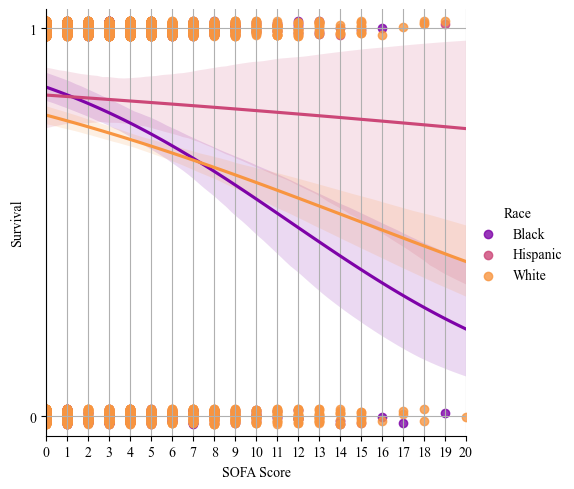

In [5]:
fig = plt.figure()
g3 = sns.lmplot(y='Survived',
            x='InitialSOFA',
            hue = 'Race',
            hue_order=['Black', 'Hispanic', 'White'], 
#            col='Race',
#            col_wrap=2,
            data = df.where(df.Race != 'AIAN'),
            y_jitter=.02, 
            logistic=True,
            truncate=False,
            palette='plasma'
)

g3 = (g3.set_axis_labels("SOFA Score", "Survival")
      .set(xlim=(0, 20), ylim=(-.05, 1.05))
      .set(xticks=range(21))
      .set(yticks=range(2))
      .fig.subplots_adjust(wspace=.02))
#plt.xticks(rotation=90)
plt.show

### Staylength OLS Models
Not utilised in final paper.

In [9]:
#calculate logit model for SOFA + Age set
results_stay_all = smf.ols('StayLength ~ InitialSOFA + Age + Sex + Race + COVID_Status', data=df).fit()
print(results_stay_all.summary())

                            OLS Regression Results                            
Dep. Variable:             StayLength   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     16.94
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           2.03e-30
Time:                        14:33:24   Log-Likelihood:                -16604.
No. Observations:                3706   AIC:                         3.323e+04
Df Residuals:                    3695   BIC:                         3.330e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           17.9422      5.479  

In [10]:
#calculate logit model for SOFA + Age set
results_stay_SOFA = smf.ols('StayLength ~ InitialSOFA', data=df).fit()
print(results_stay_SOFA.summary())

                            OLS Regression Results                            
Dep. Variable:             StayLength   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     79.12
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           8.97e-19
Time:                        14:33:28   Log-Likelihood:                -16654.
No. Observations:                3707   AIC:                         3.331e+04
Df Residuals:                    3705   BIC:                         3.332e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      14.4430      0.508     28.412      

### Individual Variable Logistic Regression for Survival

#### Survival by SOFA Score (Scatter and Logit Model)

Optimization terminated successfully.
         Current function value: 0.576059
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 3707
Model:                          Logit   Df Residuals:                     3705
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Jul 2023   Pseudo R-squ.:                 0.01953
Time:                        21:58:50   Log-Likelihood:                -2135.4
converged:                       True   LL-Null:                       -2178.0
Covariance Type:            nonrobust   LLR p-value:                 2.872e-20
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3329      0.056     23.999      0.000       1.224       1.442
InitialSOFA    -0.0922    

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

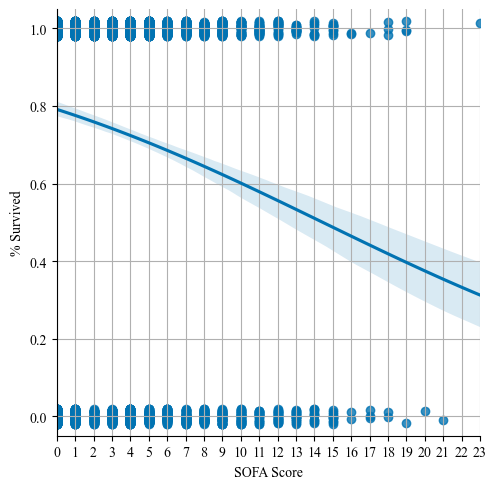

In [ ]:
#Create logitmodel of survival by SOFA score
results_survival_SOFA = smf.logit('Survived ~ InitialSOFA', data=df).fit()
print(results_survival_SOFA.summary())
print(np.exp(results_survival_SOFA.params)) #https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#calculating-odds-ratios
print(np.exp(results_survival_SOFA.conf_int()))

#Create logit plot of survival by SOFA Score
fig = plt.figure()
g = sns.lmplot(y='Survived',
            x='InitialSOFA',
            #hue = 'Race',
            #col='Race',
            #col_wrap=2,
            data = df,#.where(df.Race != "AIAN"),
            y_jitter=.02, 
            logistic=True,
            truncate=False
)

g.set(xlim=(0, 80), ylim=(-.05, 1.05))

g = (g.set_axis_labels("SOFA Score", "% Survived")
      .set(xlim=(0, 23), ylim=(-.05, 1.05))
      .set(xticks=range(24))
      .fig.subplots_adjust(wspace=.02))
#plt.xticks(rotation=90)
plt.show

#### Survival by Age (Scatter and Logit Model)

Optimization terminated successfully.
         Current function value: 0.559478
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                 3707
Model:                          Logit   Df Residuals:                     3705
Method:                           MLE   Df Model:                            1
Date:                Fri, 28 Jul 2023   Pseudo R-squ.:                 0.04775
Time:                        21:58:57   Log-Likelihood:                -2074.0
converged:                       True   LL-Null:                       -2178.0
Covariance Type:            nonrobust   LLR p-value:                 3.741e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2789      0.181     18.100      0.000       2.924       3.634
Age           -0.0359      0.

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

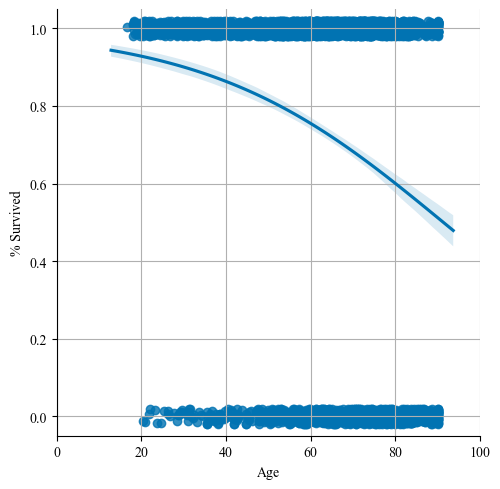

In [ ]:
#calculate using statsmodels
results_survival_age = smf.logit('Survived ~ Age', data=df).fit()
print(results_survival_age.summary())
print(np.exp(results_survival_age.params)) #https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#calculating-odds-ratios
print(np.exp(results_survival_age.conf_int()))

fig = plt.figure()
g = sns.lmplot(y='Survived',
            x='Age',
            #hue = 'Race',
            #col='Race',
            #col_wrap=2,
            data = df,#.where(df.Race != "AIAN"),
            y_jitter=.02,
            logistic=True,
            truncate=False,
            palette='colorblind'
)

g = (g.set_axis_labels("Age", "% Survived")
      .set(xlim=(0, 100), ylim=(-.05, 1.05))
#      .set(xticks=range(21))
      .fig.subplots_adjust(wspace=.02))
#plt.xticks(rotation=90)
plt.show